# Face Landmarks Detection with MediaPipe

## Preparation

In [23]:
# %pip install mediapipe

In [24]:
# !wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [25]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import sys
import face_recognition
import os

## Visualization utilities

In [26]:
def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

## Download test image

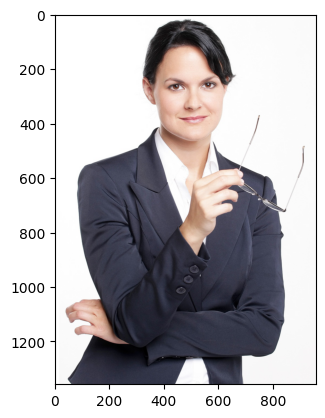

In [27]:
img = cv2.imread("image.png")
# cv2.imshow(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## Running inference and visualizing the results

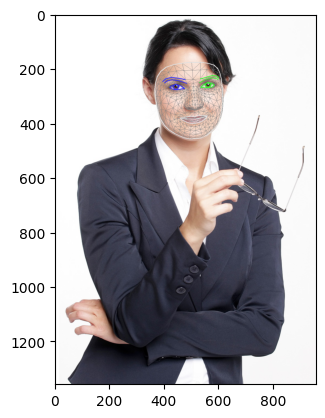

In [28]:
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.png")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
# cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
# plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.imshow(annotated_image)

plt.show()

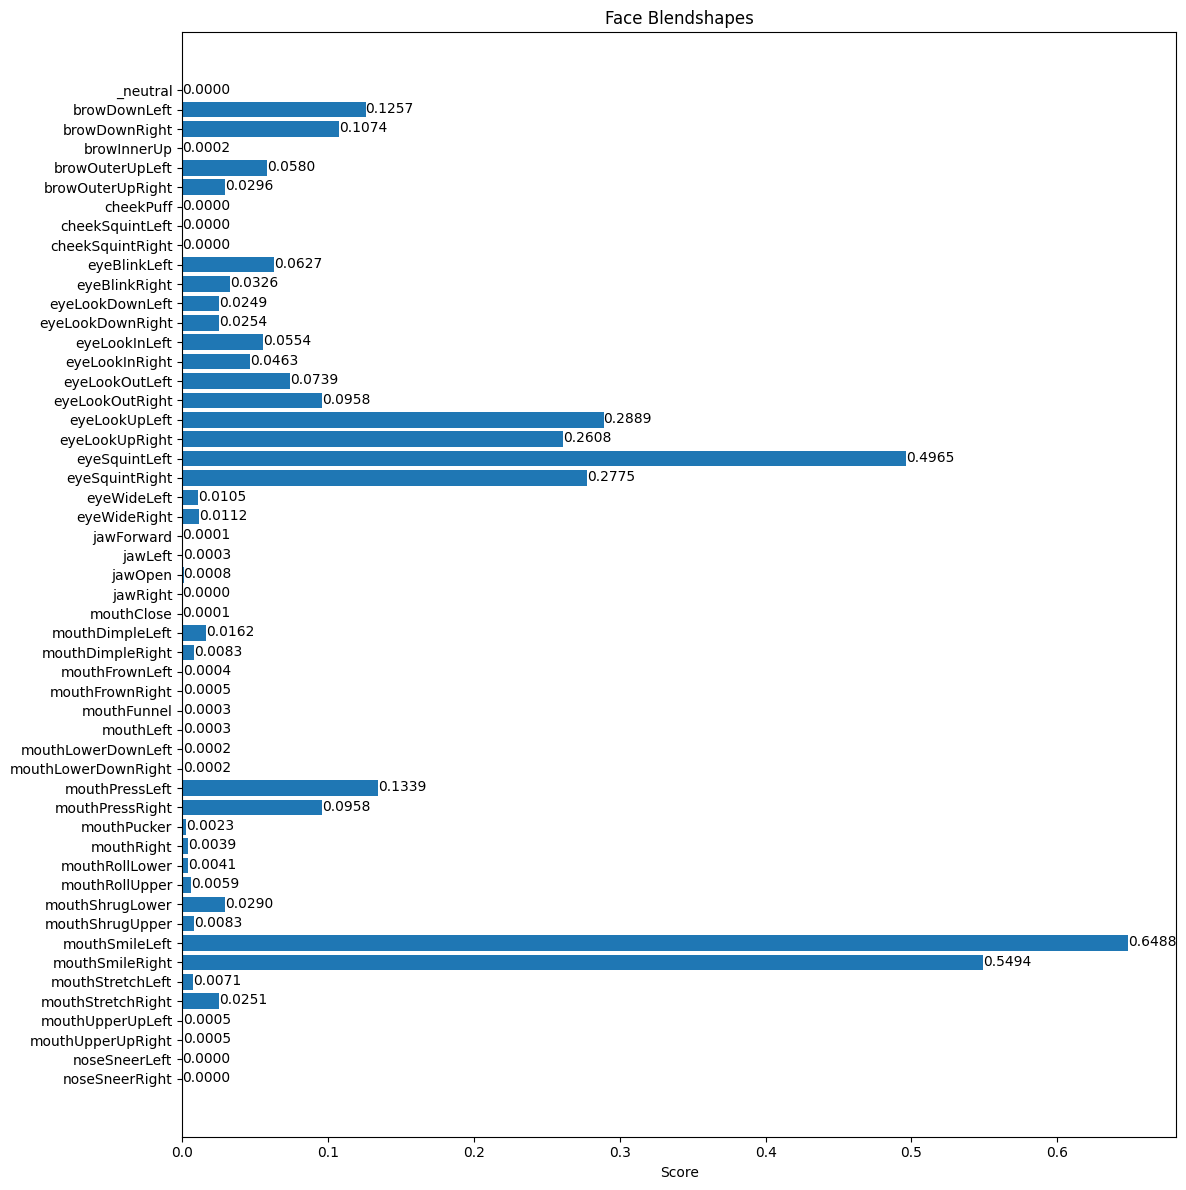

In [29]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])
# print(detection_result.face_blendshapes)

In [30]:
# Convertir les données en une liste de dictionnaires
dict_data = [vars(item) for item in detection_result.face_blendshapes[0]]

# Créer un DataFrame à partir de la liste de dictionnaires
df = pd.DataFrame(dict_data)

df.head()

,index,score,display_name,category_name
0,0,0.000003,,_neutral
1,1,0.125656,,browDownLeft
2,2,0.107417,,browDownRight
3,3,0.000151,,browInnerUp
4,4,0.058032,,browOuterUpLeft


# Enregistrements

In [31]:
ID_dame = 0
USERNAME_dame = "Dame test"
# Convertir la matrice en liste pour la rendre sérialisable
# face_blendshapes = detection_result.face_blendshapes[0] 
face_blendshapes = [str(item) for item in detection_result.face_blendshapes[0]]

# Créer un dictionnaire pour stocker l'ID de la personne et la matrice de transformation
person_data = {"person_id": ID_dame, "name": USERNAME_dame, "face_blendshapes": face_blendshapes}

# Enregistrer les données au format JSON
# Lire les données existantes
with open('./pers_data/person_data.json', 'r') as f:
    existing_data = json.load(f)

# Ajouter les nouvelles données
existing_data[str(ID_dame)] = person_data

# Réécrire les données dans le fichier
with open('./pers_data/person_data.json', 'w') as f:
    json.dump(existing_data, f)

# Avec caméra

In [32]:
model_path = "face_landmarker_v2_with_blendshapes.task"

BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
FaceLandmarkerResult = mp.tasks.vision.FaceLandmarkerResult
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a face landmarker instance with the live stream mode:
def print_result(result: FaceLandmarkerResult, output_image: mp.Image, timestamp_ms: int):
    print('face landmarker result: {}'.format(result))

options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.LIVE_STREAM,
    result_callback=print_result)

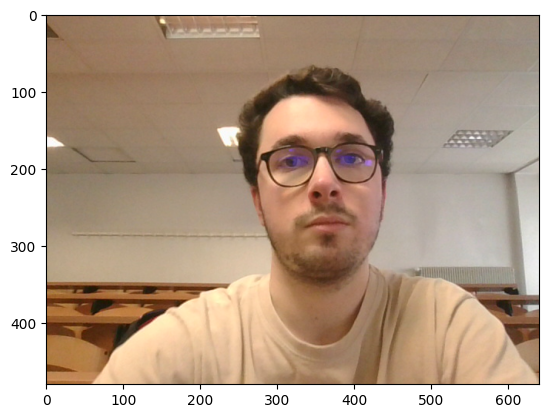

In [33]:
cap = cv2.VideoCapture(0)
# cap.read()
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Enregistrez temporairement l'image dans un fichier
cv2.imwrite('temp.png', cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

plt.imshow(frame)
plt.show()

cap.release()

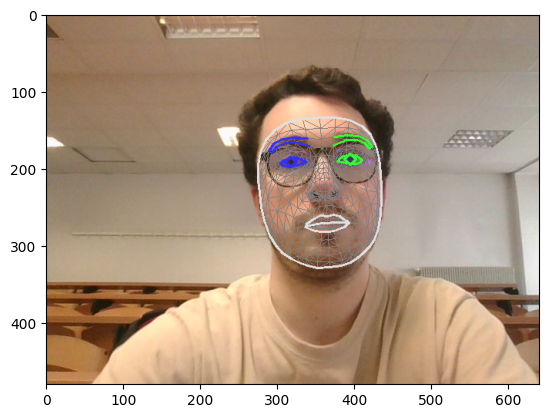

In [34]:
# image = mp.Image.create_from_file(frame)
image = mp.Image.create_from_file('temp.png')

detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
landmaked_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
# cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
# plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.imshow(landmaked_image)

plt.show()

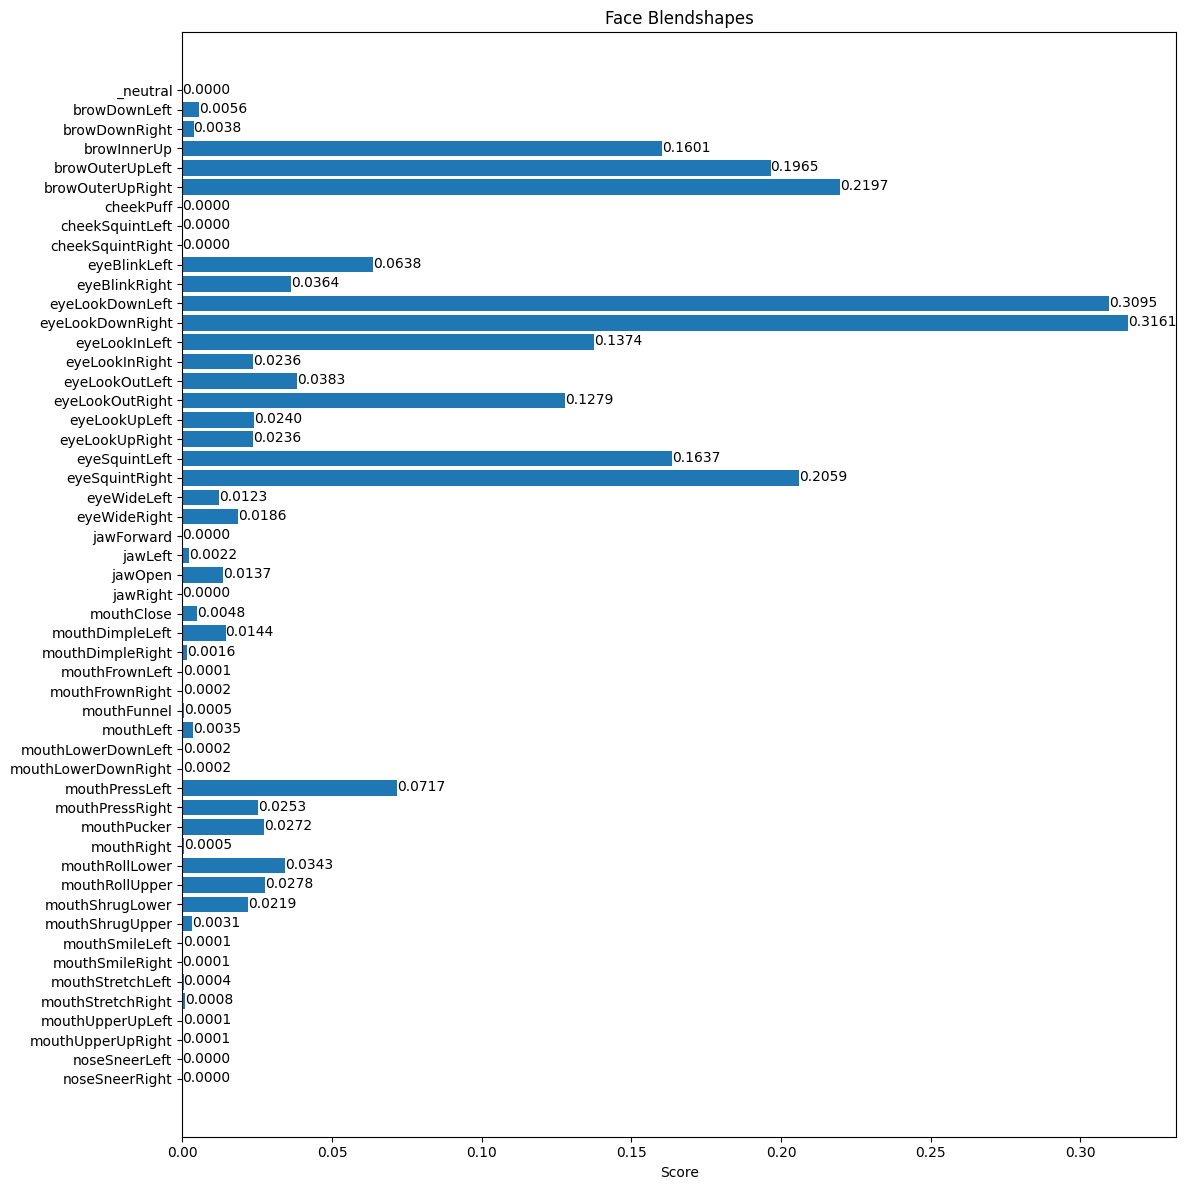

In [35]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

In [36]:
# Convertir les données en une liste de dictionnaires
dict_data = [vars(item) for item in detection_result.face_blendshapes[0]]

# Créer un DataFrame à partir de la liste de dictionnaires
df = pd.DataFrame(dict_data)

df.head()

,index,score,display_name,category_name
0,0,6.699228e-07,,_neutral
1,1,5.643814e-03,,browDownLeft
2,2,3.760129e-03,,browDownRight
3,3,1.601487e-01,,browInnerUp
4,4,1.965085e-01,,browOuterUpLeft


In [37]:
ID_nico = 1
USERNAME_nico = "Nico"
# Convertir la matrice en liste pour la rendre sérialisable
# face_blendshapes = detection_result.face_blendshapes[0] 
face_blendshapes = [str(item) for item in detection_result.face_blendshapes[0]]

# Créer un dictionnaire pour stocker l'ID de la personne et la matrice de transformation
person_data = {"person_id": ID_nico, "name": USERNAME_nico, "face_blendshapes": face_blendshapes}

# Lire les données existantes
with open('./pers_data/person_data.json', 'r') as f:
    existing_data = json.load(f)

# Ajouter les nouvelles données
existing_data[str(ID_nico)] = person_data

# Réécrire les données dans le fichier
with open('./pers_data/person_data.json', 'w') as f:
    json.dump(existing_data, f)

# Retrouver un visage

In [42]:


# cascPath = sys.argv[1]
# faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


# while True:
#     # Capture frame-by-frame
#     ret, frame = video_capture.read()

#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     faces = faceCascade.detectMultiScale(
#         gray,
#         scaleFactor=1.1,
#         minNeighbors=5,
#         minSize=(30, 30),
#         flags=cv2.CASCADE_SCALE_IMAGE
#     )

#     # Draw a rectangle around the faces and recognize them
#     for (x, y, w, h) in faces:
#         cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

#         # Recognize the face
#         # face_encoding = face_recognition.face_encodings(frame[y:y+h, x:x+w])[0]
#         # matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
#         # name = "Inconnu"
        
#         # if True in matches:
#         #     first_match_index = matches.index(True)
#         #     name = known_face_names[first_match_index]

#         # Draw the name of the face
#         # cv2.putText(frame, known_face_names, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
        
#         print(known_face_names)

#     # Display the resulting frame
#     cv2.imshow('Video', frame)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # When everything is done, release the capture
# video_capture.release()
# cv2.destroyAllWindows()

['Dame test', 'Nico']
[["Category(index=0, score=2.7253367989032995e-06, display_name='', category_name='_neutral')", "Category(index=1, score=0.1256556361913681, display_name='', category_name='browDownLeft')", "Category(index=2, score=0.10741706192493439, display_name='', category_name='browDownRight')", "Category(index=3, score=0.0001509089197497815, display_name='', category_name='browInnerUp')", "Category(index=4, score=0.05803176015615463, display_name='', category_name='browOuterUpLeft')", "Category(index=5, score=0.029591243714094162, display_name='', category_name='browOuterUpRight')", "Category(index=6, score=3.763048516702838e-05, display_name='', category_name='cheekPuff')", "Category(index=7, score=2.0550118051687605e-07, display_name='', category_name='cheekSquintLeft')", "Category(index=8, score=2.673679659892514e-07, display_name='', category_name='cheekSquintRight')", "Category(index=9, score=0.06272823363542557, display_name='', category_name='eyeBlinkLeft')", "Catego

In [50]:
# Charger les données de visages connus
with open('./pers_data/person_data.json', 'r') as f:
    known_faces_data = json.load(f)

# Convertir les données de visages connus en listes
known_face_names = [data['name'] for data in known_faces_data.values()]
known_face_encodings = [data['face_blendshapes'] for data in known_faces_data.values()]

# print(known_face_names)
# print(known_face_encodings)

process_this_frame = True

while True:
    # Grab a single frame of video
    video_capture = cv2.VideoCapture(0)
    
    ret, frame = video_capture.read()

    # Only process every other frame of video to save time
    if process_this_frame:
        # Resize frame of video to 1/4 size for faster face recognition processing
        # small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)

        # # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
        # rgb_small_frame = small_frame[:, :, ::-1]
        
        # Find all the faces and face encodings in the current frame of video
        face_locations = face_recognition.face_locations(frame)
        # face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

        
        for face_blenshapes in known_face_encodings:
            # Convert lists to numpy arrays
            known_face_encodings_np = np.array(known_face_encodings)
            face_blenshapes_np = np.array(face_blenshapes)
            
            
            
            # See if the face is a match for the known face(s)
            matches = face_recognition.compare_faces(known_face_encodings_np, face_blenshapes_np)
            name = "Unknown"

            # If a match was found in known_face_encodings, just use the first one.
            if True in matches:
                first_match_index = matches.index(True)
                name = known_face_names[first_match_index]

            # Or instead, use the known face with the smallest distance to the new face
            face_distances = face_recognition.face_distance(known_face_encodings_np, face_blenshapes_np)
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = known_face_names[best_match_index]

            known_face_names.append(name)

    process_this_frame = not process_this_frame


    # Display the results
    for (top, right, bottom, left), name in zip(face_locations, known_face_names):
        # Scale back up face locations since the frame we detected in was scaled to 1/4 size
        top *= 4
        right *= 4
        bottom *= 4
        left *= 4

        # Draw a box around the face
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

        # Draw a label with a name below the face
        cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

    # Display the resulting image
    cv2.imshow('Video', frame)

    # Hit 'q' on the keyboard to quit!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release handle to the webcam
video_capture.release()
cv2.destroyAllWindows()

AttributeError: 'list' object has no attribute 'split'